Technniki inteligencji obliczeniowej - Multi Layer Perceptron

Dane:

Autorzy: Adrian Broniecki, Mateusz Gazda

In [5]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(x_train.shape)
print(y_train.shape) 

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)
(60000,)


In [7]:
print(np.isnan(x_train).any())
print(np.isnan(y_train).any())

False
False


In [9]:
x_train = x_train.reshape((60000, 28 * 28)).astype('float32') / 255
x_test = x_test.reshape((10000, 28 * 28)).astype('float32') / 255

In [10]:
def my_to_categorical(y, num_classes=None):
    """
    Convert class vector (integers) to one-hot encoded matrix.
    
    Parameters:
    y : array-like of shape (n_samples,)
        Class labels as integers.
    num_classes : int, optional
        Total number of classes. If None, it is inferred from the data.
    
    Returns:
    onehot : ndarray of shape (n_samples, num_classes)
        One-hot encoded labels as float32.
    """
    y = np.asarray(y)
    if num_classes is None:
        num_classes = np.max(y) + 1

    onehot = np.zeros((y.shape[0], num_classes), dtype=np.float32)

    onehot[np.arange(y.shape[0]), y] = 1.0

    return onehot

In [11]:
y_train = my_to_categorical(y_train, num_classes=10)
y_test = my_to_categorical(y_test, num_classes=10)

In [12]:
x_train, x_val = x_train[:48000], x_train[48000:]
y_train, y_val = y_train[:48000], y_train[48000:]

In [ ]:
class NumpyMLP:
    def __init__(self, input_shape=(784,), hidden_units=[256,128], activation='relu', dropout_rate=0.0, num_classes=10, lr=0.01):
        self.input_shape = input_shape
        self.hidden_units = hidden_units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes
        self.lr = lr
        self.weights, self.biases = self._init_weights()

In [ ]:


def create_mlp(input_shape=(784,), 
               hidden_units=[256, 128], 
               activation='relu', 
               dropout_rate=0.3, 
               num_classes=10,
               backend='keras'):
    """
    Create a customizable MLP model with Keras or NumPy backend.

    Parameters:
    -----------
    input_shape : tuple
        Shape of the input vector (default 784 for MNIST flattened).
    hidden_units : list of int
        Number of neurons in each hidden layer (default [256, 128]).
    activation : str
        Activation function for hidden layers (e.g., 'relu', 'tanh', 'sigmoid').
    dropout_rate : float
        Dropout rate applied after each hidden layer (0 = no dropout).
    num_classes : int
        Number of output classes (default 10 for MNIST).
    backend : str
        Backend to use ('keras' or 'numpy').

    Returns:
    --------
    model : tf.keras.Model
        Compiled MLP model ready for training.
    """

    if backend == 'keras':
        model = Sequential()
        model.add(Dense(hidden_units[0], activation=activation, input_shape=input_shape))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
        for units in hidden_units[1:]:
            model.add(Dense(units, activation=activation))
            if dropout_rate > 0:
                model.add(Dropout(dropout_rate))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    elif backend == 'numpy':
        return NumpyMLP(input_shape=input_shape, hidden_units=hidden_units,
                        activation=activation, dropout_rate=dropout_rate,
                        num_classes=num_classes)
    else:
        raise ValueError("backend must be 'keras' or 'numpy'")

In [14]:
model = create_mlp(hidden_units=[256, 128], activation='relu', dropout_rate=0.3)

c:\Users\Adrian\Desktop\Magisterka\SEMESTR2\TIO\Labolatorium\TIO\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
def train_model(model, x_train, y_train, x_val, y_val,
                optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'], epochs=15, batch_size=128):
    """
    Compile and train the MLP model.
    Returns trained model and training history.
    """
    # Select optimizer
    if optimizer.lower() == 'adam':
        opt = tf.keras.optimizers.Adam()
    elif optimizer.lower() == 'sgd':
        opt = tf.keras.optimizers.SGD()
    else:
        opt = tf.keras.optimizers.get(optimizer)

    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=metrics)

    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)
    return model, history

In [20]:
def hyperparameter_search(x_train, y_train, x_val, y_val,
                                   hidden_units_list=[[128], [256, 128]],
                                   activations=['relu', 'tanh'],
                                   dropout_rates=[0.0, 0.3, 0.5],
                                   optimizers=['adam', 'sgd'],
                                   losses=['categorical_crossentropy'],
                                   metrics_list=[['accuracy', 'precision', 'recall', 'TopKCategoricalAccuracy']],
                                   epochs=[5, 10, 15, 20],
                                   batch_size=128):
    """
    Test all combinations of hyperparameters and return results DataFrame.
    """
    results = []

    for hidden_units, activation, dropout_rate, optimizer, loss, metrics, epochs_n in itertools.product(
        hidden_units_list, activations, dropout_rates, optimizers, losses, metrics_list, epochs
    ):
        print(f"Testing: hidden_units={hidden_units}, activation={activation}, dropout={dropout_rate}, optimizer={optimizer}, loss={loss}")
        model = create_mlp(hidden_units=hidden_units, activation=activation, dropout_rate=dropout_rate)
        model, history = train_model(model, x_train, y_train, x_val, y_val,
                                     optimizer=optimizer, loss=loss, metrics=metrics,
                                     epochs=epochs_n, batch_size=batch_size)

        val_acc = max(history.history[metrics[0]])
        results.append({
            'hidden_units': hidden_units,
            'activation': activation,
            'dropout_rate': dropout_rate,
            'optimizer': optimizer,
            'loss': loss,
            'metrics': metrics,
            'val_accuracy': val_acc,
            'model': model,
            'history': history
        })

    return pd.DataFrame(results)


results = hyperparameter_search(
    x_train, y_train,
    x_val, y_val,
    hidden_units_list=[[128], [256,128]],
    activations=['relu', 'tanh'],
    dropout_rates=[0.0, 0.3],
    optimizers=['adam', 'sgd'],
    losses=['categorical_crossentropy'],
    metrics_list=[['accuracy'], ['accuracy','TopKCategoricalAccuracy']],
    epochs=[5, 10, 15, 20]
)

results_sorted = results.sort_values(by='val_accuracy', ascending=False)
print(results_sorted.head(10))

Testing: hidden_units=[128], activation=relu, dropout=0.0, optimizer=adam, loss=categorical_crossentropy
Epoch 1/5


c:\Users\Adrian\Desktop\Magisterka\SEMESTR2\TIO\Labolatorium\TIO\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5535 - loss: 1.9180 - val_accuracy: 0.7232 - val_loss: 1.3625
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7686 - loss: 1.0515 - val_accuracy: 0.8247 - val_loss: 0.7985
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8338 - loss: 0.7016 - val_accuracy: 0.8641 - val_loss: 0.5789
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8642 - loss: 0.5477 - val_accuracy: 0.8841 - val_loss: 0.4712
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8799 - loss: 0.4665 - val_accuracy: 0.8932 - val_loss: 0.4131
Testing: hidden_units=[128], activation=relu, dropout=0.0, optimizer=adam, loss=categorical_crossentropy
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5403 - loss: 1.9382 - val_accuracy: 0.7132 - val_loss: 1.4011
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7533 - loss: 1.0872 - val_accuracy: 0.8196 - val_loss: 0.8299
Epoch 3/10
375

In [21]:
def plot_learning_curves(history):
    """
    Plot train and validation accuracy/loss curves from history.
    """
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    plt.show()

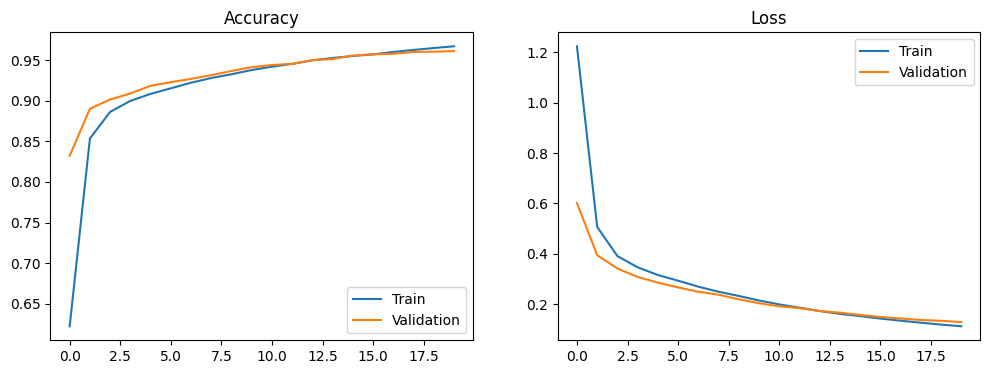

In [22]:
best_row = results_sorted.iloc[0]
best_model = best_row['model']
best_history = best_row['history']

plot_learning_curves(best_history)

In [23]:
def evaluate_model(model, x_test, y_test, top_n_wrong=10):
    """
    Evaluate model on test set and show misclassified examples.
    """
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {test_acc:.4f}")

    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    wrong = np.where(y_pred != y_true)[0]
    print(f"Number of misclassified examples: {len(wrong)}")

    plt.figure(figsize=(12,6))
    for i, idx in enumerate(wrong[:top_n_wrong]):
        plt.subplot(2, top_n_wrong//2, i+1)
        plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
        plt.title(f"True:{y_true[idx]}, Pred:{y_pred[idx]}")
        plt.axis('off')
    plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9269 - loss: 20.8291
Test accuracy: 0.9269
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
Number of misclassified examples: 731


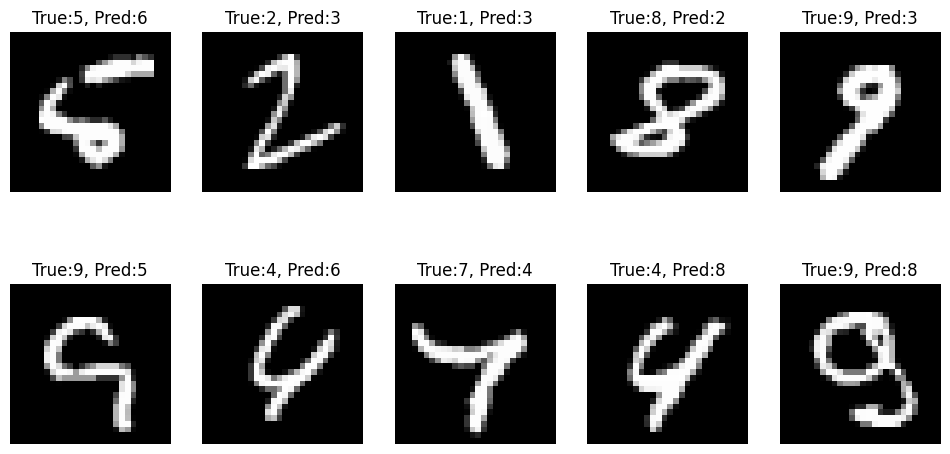

In [24]:
evaluate_model(best_model, x_test, y_test)